# Initialisation

In [5]:
#import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd
from glob import glob,iglob
import pickle
#import seaborn as sns
import os, sys
sys.setrecursionlimit(10**7)
import panedr
import subprocess as sp
import MDAnalysis as mda
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
import matplotlib.gridspec as gridspec
#import onsager
plt.style.use('~/hargu_seaborn.mplstyle')
from ase.io import read,write
from ase.visualize import view
from ase.io.trajectory import Trajectory
import nglview
#from tame.io import load_traj
#from tame.fit import linear_fit
def mlog(x,a,b):
    return a*np.power(x,b)

def biexp(x,a1,a2,b1,b2):
    return (1-a1-a2)+a1*np.exp(-x/b1)+a2*np.exp(-x/b2)

def f_x(x,a):
    return a/x
def fx(x,b):
    return -b*x

def polycoeffs(x, coeffs):
    """ Returns a polynomial for ``x`` values for the ``coeffs`` provided.

    The coefficients must be in ascending order (``x**0`` to ``x**o``).
    """
    o = len(coeffs)
    print(f'# This is a polynomial of order {ord}.')
    y = 0
    for i in range(o):
        y += coeffs[i]*x**i
    return y

#%load_ext gnuplot_kernel
#%reload_ext gnuplot_kernel

#Functions to calculate average and stanard deviation of 2 or more PMSDs from different segments of the simulation
def scol_avg_std(cor,conc,cs,tk,col): 
    #cor(string)-which type of correlation to consider eg. pmsd or corr
    #chr(integer)-which charge scheme eg. 0:p150s100, 5: p150s75 
    #col(string)-which coloumn to consider eg. 'PMSD','distliN' 
    sum=0;average=0;diffsquared = 0;sum_diffsquared = 0;
    n=len(cor[conc][cs][tk]) #n(integer)-number of segments for S75-2 and S100-3 or more
    for i in range(n):
        sum=sum+cor[conc][cs][tk][i][col]
    sum=sum
    average=sum/n
    for i in range(n):
        diffsquared=(cor[conc][cs][tk][i][col] - average)**2
        sum_diffsquared=sum_diffsquared+diffsquared
    stddev=((sum_diffsquared)/n)**(1/2)
    
    return average,stddev

def col_avg_std(cor,conc,col): 
    #cor(string)-which type of correlation to consider eg. pmsd or corr
    #chr(integer)-which charge scheme eg. 0:p150s100, 5: p150s75 
    #col(string)-which coloumn to consider eg. 'PMSD','distliN' 
    sum=0;average=0;diffsquared = 0;sum_diffsquared = 0;
    n=len(cor[conc]) #n(integer)-number of segments for S75-2 and S100-3 or more
    for i in range(n):
        sum=sum+cor[conc][i][col]
    sum=sum
    average=sum/n
    for i in range(n):
        diffsquared=(cor[conc][i][col] - average)**2
        sum_diffsquared=sum_diffsquared+diffsquared
    stddev=((sum_diffsquared)/n)**(1/2)
    
    return average,stddev

def line(x,m,c):
    return m*x+c
##https://reader.elsevier.com/reader/sd/pii/S003238611630074X?token=964C73218EF46E4B1D21A7BFAA533DAF02A78AD3C68728A049B766A7725EDF3DB8D80FC98810D75D0381E9CAD9D415B7&originRegion=eu-west-1&originCreation=20210611120737
def xi(m1,c1,m2,c2):
    xi = (c1-c2) / (m2-m1)
    return xi
def yi(m1,c1,m2,c2):
    xi = (c1-c2) / (m2-m1)
    yi = m1 * xi + c1
    return yi


In [6]:
MDDIR='/cfs/klemming/nobackup/h/hargu978/Cuc_kristina_SelfHealing_polymer/MD'
ANADIR='/cfs/klemming/nobackup/h/hargu978/Cuc_kristina_SelfHealing_polymer/analysis'


## Data

In [68]:
#Initial dataframe that consits all details of the simulations

#This dataframe is saved as npy file (see next cell).

#Convert this cell from RawNbConvert to Code by typing Ctr+Y
#Run this cell carefully dont overwrite the current file if needed change the file names
#data={}
#form=['C27H48O10','C147H248O50','C603H1008O202','C1491H2488O498']
#mw=[532.665198,2815.518398,11490.360558,28383.474238]

for egr in ['OH','SLF']:
    #data[egr]={}
    #data[egr]['mw.']=mw[i] ## Molecular weight
    #data[egr]['formula']=form[i] ## Chemical Formula
    for nmon,npol in zip([16,80],[30,6]):
        #data[egr][nmon]={}
        for conc in [0,0.125]:
            #data[egr][nmon][conc]=pd.DataFrame(columns=['nmon','npol','conc','T','Volume','Density'])
            for rw,temp in enumerate([400,500]):
                data[egr][nmon][conc].at[rw,'nmon']=nmon
                data[egr][nmon][conc].at[rw,'npol']=npol
                data[egr][nmon][conc].at[rw,'conc']=conc
                data[egr][nmon][conc].at[rw,'T']=temp
            
data[egr][nmon][conc]

,nmon,npol,conc,T,Volume,Density,Volume_std,Density_std,Tg,dens_atTg
0,80,6,0.125,400,129.336,1188.02,387.937146,3563.390156,319.054321,1245.636242
1,80,6,0.125,500,NaN,NaN,NaN,NaN,319.054321,1245.636242


In [7]:
#Dump this dictionary to a npy file and can reload again when needed
#np.save('analysis_data.npy', data)
#np.save('analysis_data_backup.npy', data)

#Loading the saved dictionary
data=np.load('analysis_data.npy',allow_pickle=True).item()

#To add new coloumn just type df[nmon[i]][conc[c]]['NEW-COLOUM']=NEW COLOUMN DATA

In [72]:
data[egr][nmon][conc]

,nmon,npol,conc,T,Volume,Density,Volume_std,Density_std,Tg,dens_atTg
0,80,6,0.125,400,129.336,1188.02,387.937146,3563.390156,319.054321,1245.636242
1,80,6,0.125,500,NaN,NaN,NaN,NaN,319.054321,1245.636242


## Folders

In [95]:
#making folders
anatype='hbond' #'rdf_cn' 'msd' 'cond' 'restime' 'hbond'
%mkdir {ANADIR}/{anatype}
%cd {ANADIR}/{anatype}
for egr in ['OH','SLF']:
    %mkdir PCL_PTM_{egr}
    for nmon in [16,80]:
        %mkdir PCL_PTM_{egr}/{nmon}mer
        for conc in [0,0.125]:
            %mkdir PCL_PTM_{egr}/{nmon}mer/{conc}
            for temp in [400,500]:
                %mkdir PCL_PTM_{egr}/{nmon}mer/{conc}/{temp}

%cd {ANADIR}

/cfs/klemming/nobackup/h/hargu978/Cuc_kristina_SelfHealing_polymer/analysis/hbond
/cfs/klemming/nobackup/h/hargu978/Cuc_kristina_SelfHealing_polymer/analysis


## Updating Volume and Density

OH 16 0


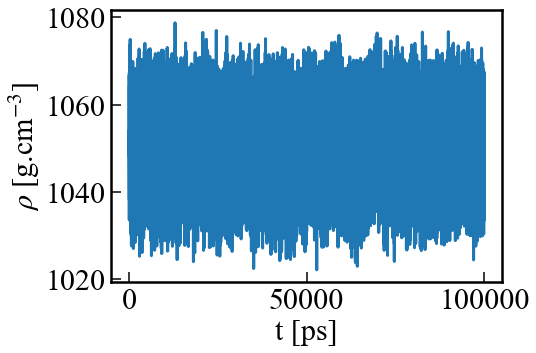

OH 16 0.125


KeyboardInterrupt: 

In [9]:
#Updating volume and density
for egr in ['OH','SLF']:
    for nmon,npol in zip([16,80],[30,6]):
        for conc in [0,0.125]:
            for rw,temp in enumerate([400]):
                print(egr,nmon,conc)
                edr=panedr.edr_to_df(str(MDDIR)+'/PCL_PTM_'+str(egr)+'/'+str(nmon)+'mer/'+str(conc)+'/'+str(temp)+'/npt_prod.edr')
                plt.plot(edr['Time'],edr['Density'])
                plt.xlabel('t [ps]');plt.ylabel(r'$\rho$ [g.cm$^{-3}$]')
                plt.show()
                for prop in ['Volume','Density']:
                    bsize=500; ##2.5 ns
                    nbox=int(len(edr)/bsize);
                    averages=np.zeros(nbox);
                    for i in range(nbox):
                        averages[i]=np.sum(edr[prop][i*bsize:(i+1)*bsize])/bsize

                    data[egr][nmon][conc].at[rw,prop]=np.average(averages)
                    #data[egr][nmon][conc].at[rw,str(prop)+'_std']=np.std(averages)

In [53]:
data

{'OH': {16: {0:   nmon npol conc    T   Volume  Density  edr  Volume_std  Density_std
   0   16   30    0  400  109.618  1050.55  NaN  328.854486  3151.659748
   1   16   30    0  450      NaN      NaN  NaN         NaN          NaN,
   0.125:   nmon npol   conc    T   Volume  Density  Volume_std  Density_std
   0   16   30  0.125  400  128.017  1181.51  383.464447  3539.133001
   1   16   30  0.125  450      NaN      NaN         NaN          NaN},
  80: {0:   nmon npol conc    T   Volume  Density  Volume_std  Density_std
   0   80    6    0  400  106.502  1052.81  319.505163  3158.424899
   1   80    6    0  450      NaN      NaN         NaN          NaN,
   0.125:   nmon npol   conc    T   Volume Density  Volume_std  Density_std
   0   80    6  0.125  400  124.944  1186.9  373.819731  3551.034795
   1   80    6  0.125  450      NaN     NaN         NaN          NaN}},
 'SLF': {16: {0:   nmon npol conc    T   Volume  Density  Volume_std  Density_std
   0   16   30    0  400  132.091  10

# Glass transition temperature

## Loading data and plotting

In [ ]:
#%%bash
#Loading edr files and saving density and volume values
MDDIR=/cfs/klemming/nobackup/h/hargu978/Cuc_kristina_SelfHealing_polymer/MD
#%cd $SYSDIR
for egr in OH SLF;do
    for nmon in 80;do #16
        for conc in 0 0.125;do 
            edr=$MDDIR/PCL_PTM_$egr/${nmon}mer/$conc/Tg/npt.edr
            out=$MDDIR/PCL_PTM_$egr/${nmon}mer/$conc/Tg/temp_dens_vol.xvg
            gmx energy -f $edr -o $out
        done
    done
done


OH 16 0
OH 16 0.125
OH 80 0
OH 80 0.125


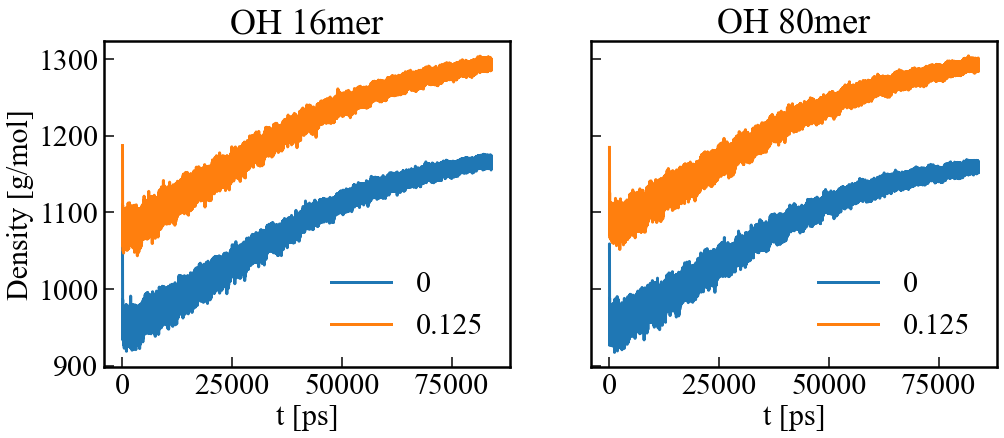

SLF 16 0
SLF 16 0.125
SLF 80 0
SLF 80 0.125


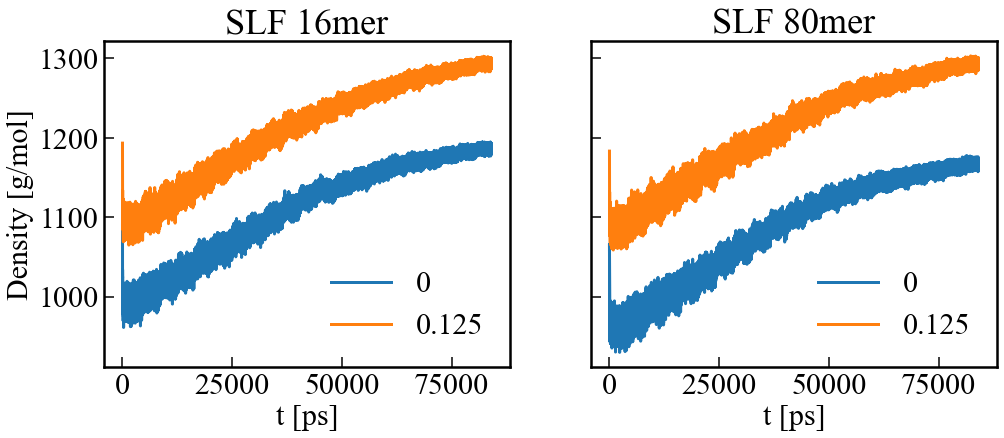

In [6]:
#Loading, plotting and saving energy files (temp. vs dens. data)
dens={}
for egr in ['OH','SLF']:
    dens[egr]={}
    fig, axs = plt.subplots(1,2,figsize=(8*2,6*1),sharex=True,sharey=True)
    for n,nmon in enumerate([16,80]):
        dens[egr][nmon]={}
        for conc in [0,0.125]:
            print(egr,nmon,conc)
            dir=str(MDDIR)+'/PCL_PTM_'+str(egr)+'/'+str(nmon)+'mer/'+str(conc)+'/Tg/temp_dens_vol.xvg'
            ene=np.loadtxt(str(dir),skiprows=26,unpack=True)
            
            ax=axs[n]
            ax.plot(ene[0],ene[3],label=str(conc))
            ax.set_xlabel('t [ps]');axs[0].set_ylabel('Density [g/mol]')
            ax.set_title(str(egr)+' '+str(nmon)+'mer')
            ax.legend()
            
            dens[egr][nmon][conc]=pd.DataFrame(columns=['T_mean','T_std','D_mean','D_std'])
            for x,s in enumerate(np.arange(20000,840000,40000)):
                dens[egr][nmon][conc].at[x,'T_mean']=ene[1][s:s+20000].mean()
                dens[egr][nmon][conc].at[x,'T_std']=ene[1][s:s+20000].std()
                dens[egr][nmon][conc].at[x,'D_mean']=ene[3][s:s+20000].mean()
                dens[egr][nmon][conc].at[x,'D_std']=ene[3][s:s+20000].std()


    plt.show()



## Save/Load dictionary and fiting/save Tg values

In [8]:
#Dump this dictionary to a npy file and can reload again when needed
#np.save('temp_vs_density.npy', dens)

#Loading the saved dictionary
dens=np.load('temp_vs_density.npy',allow_pickle=True).item()

In [8]:
dens['OH'][16][0]

,T_mean,T_std,D_mean,D_std
0,540.041,4.76012,952.031,8.24555
1,520.012,4.52277,967.332,7.69586
2,500.229,4.4347,978.89,7.66208
3,480.241,4.17995,994.799,7.28069
4,460.132,4.08465,1008.58,6.81107
5,440.105,3.8132,1022.17,6.66269
6,420.224,3.68137,1036.59,6.65139
7,399.952,3.56409,1053.33,5.78279
8,380.035,3.31374,1065.15,5.82897
9,359.904,3.15063,1078.24,5.11165


OH 16 0 17.8 1127.0210481261101
OH 16 0.125 28.75 1250.4690270717124
OH 80 0 28.95 1123.8280556823381
OH 80 0.125 42.25 1245.3687214090676
SLF 16 0 35.15 1150.2214017035415
SLF 16 0.125 46.47 1247.9056374371844
SLF 80 0 19.06 1132.954532601444
SLF 80 0.125 46.05 1245.636242385513


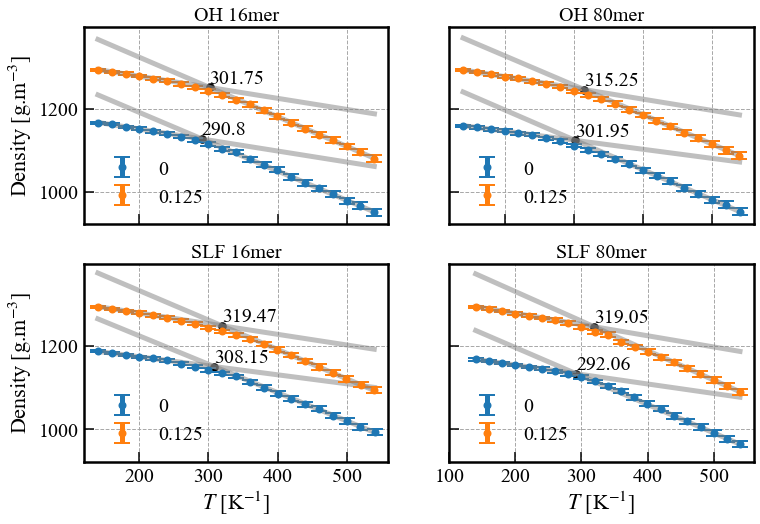

In [8]:
fig, axs = plt.subplots(2,2,figsize=(6*2,4*2),sharex=True,sharey=True)
for e,egr in enumerate(['OH','SLF']):
    for n,nmon in enumerate([16,80]): 
        for conc in [0, 0.125]: 
            ax=axs[e,n]
            df = dens[egr][nmon][conc]
            ax.errorbar(df['T_mean'], df['D_mean'], yerr=df['D_std'],label=conc, ls='', marker='o',capsize=8, capthick=2)
            #ax.scatter(df['T_mean'], df['D_mean'], label=conc,marker='o')

            #High temperature region 
            ht,_=curve_fit(line,df['T_mean'][0:6],df['D_mean'][0:6],sigma=df['D_std'][0:6]) 

            #Low temperature region
            lt,_=curve_fit(line,df['T_mean'][15:],df['D_mean'][15:],sigma=df['D_std'][15:]) 

            ax.plot(df["T_mean"],line(df["T_mean"],*ht),c='grey',ls='-',alpha=0.5)
            ax.plot(df["T_mean"],line(df["T_mean"],*lt),c='grey',ls='-',alpha=0.5)

            ax.scatter(xi(ht[0],ht[1],lt[0],lt[1]),yi(ht[0],ht[1],lt[0],lt[1]),color='k')
            ax.text(xi(ht[0],ht[1],lt[0],lt[1]),yi(ht[0],ht[1],lt[0],lt[1])+10,(np.round(xi(ht[0],ht[1],lt[0],lt[1]),2)))
            print(egr,nmon,conc,np.round(xi(ht[0],ht[1],lt[0],lt[1])-273,2),yi(ht[0],ht[1],lt[0],lt[1])) #ht[0]=m

            #Save to data 
            data[egr][nmon][conc]['Tg']=xi(ht[0],ht[1],lt[0],lt[1])
            data[egr][nmon][conc]['dens_atTg']=yi(ht[0],ht[1],lt[0],lt[1])


            ax.legend(loc='lower left') #bbox_to_anchor=[1,1]
            ax.set_title(str(egr)+' '+str(nmon)+'mer')
            axs[e,0].set_ylabel(r'Density [g.m$^{-3}$]')
            axs[1,n].set_xlabel(r'$T$ [K$^{-1}$]')
            ax.set_xticks([100,200,300,400,500])
plt.show()


## Plotting Tg

Text(0, 0.5, 'T$_g$ [C]')

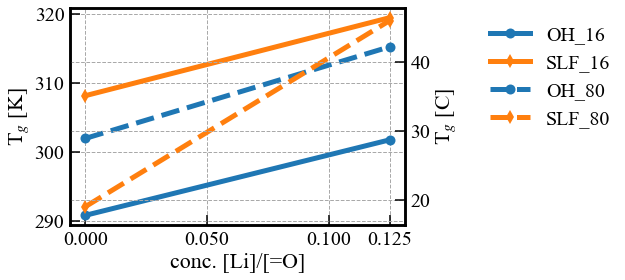

In [36]:
fig, axs = plt.subplots(1,1,figsize=(6*1,4*1),sharex=True,sharey=True)
ax=axs

ax.plot([0,0.125],[data['OH'][16][conc]['Tg'][0] for conc in [0,0.125]],c='tab:blue',marker='o',label='OH_16',markersize=10)
ax.plot([0,0.125],[data['SLF'][16][conc]['Tg'][0] for conc in [0,0.125]],c='tab:orange',marker='d',label='SLF_16',markersize=10)
ax.plot([0,0.125],[data['OH'][80][conc]['Tg'][0] for conc in [0,0.125]],c='tab:blue',marker='o',ls='--',label='OH_80',markersize=10)
ax.plot([0,0.125],[data['SLF'][80][conc]['Tg'][0] for conc in [0,0.125]],c='tab:orange',marker='d',ls='--',label='SLF_80',markersize=10)

ax.legend(bbox_to_anchor=[1.2,1])
ax.set_xlabel('conc. [Li]/[=O]')
ax.set_ylabel('T$_g$ [K]')
ax.set_xticks([0.0,0.05,0.1,0.125])
mn,mx=ax.get_ylim()

ax2=ax.twinx()
ax2.set_ylim(mn-273,mx-273)
ax2.set_ylabel('T$_g$ [C]')
#ax.set_ylim(280,330)

Text(0, 0.5, 'T$_g$ [C]')

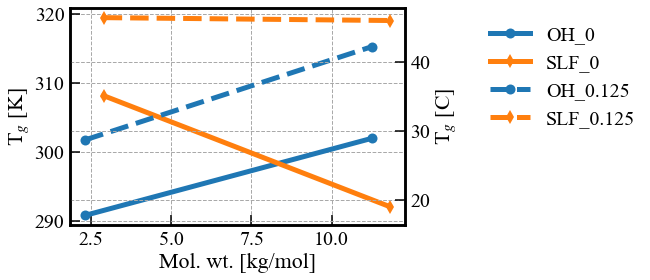

In [11]:
fig, axs = plt.subplots(1,1,figsize=(6*1,4*1),sharex=True,sharey=True)
ax=axs
mwOH=[2.31,11.25];mwSLF=[2.88,11.82]
ax.plot(mwOH,[data['OH'][nmon][0]['Tg'][0] for nmon in [16,80]],c='tab:blue',marker='o',label='OH_0',markersize=10)
ax.plot(mwSLF,[data['SLF'][nmon][0]['Tg'][0] for nmon in [16,80]],c='tab:orange',marker='d',label='SLF_0',markersize=10)
ax.plot(mwOH,[data['OH'][nmon][0.125]['Tg'][0] for nmon in [16,80]],c='tab:blue',marker='o',ls='--',label='OH_0.125',markersize=10)
ax.plot(mwSLF,[data['SLF'][nmon][0.125]['Tg'][0] for nmon in [16,80]],c='tab:orange',marker='d',ls='--',label='SLF_0.125',markersize=10)

ax.legend(bbox_to_anchor=[1.2,1])
ax.set_xlabel('Mol. wt. [kg/mol]')
ax.set_ylabel('T$_g$ [K]')
#ax.set_xticks([0.0,0.05,0.1,0.125])
mn,mx=ax.get_ylim()

ax2=ax.twinx()
ax2.set_ylim(mn-273,mx-273)
ax2.set_ylabel('T$_g$ [C]')
#ax.set_ylim(280,330)